Dataset

https://www.dati.lombardia.it/Sanit-/Dataset-SDO-Regione-Lombardia/jv9t-c6q6

https://www.dati.lombardia.it/Sanit-/Dataset-condizioni-di-salute-per-provincia-e-gener/92eu-vwkf

https://www.dati.lombardia.it/Sanit-/Georeferenziazione-strutture/6n7g-5p5e

https://www.dati.lombardia.it/Sanit-/Dataset-Assistenza-Ospedaliera-per-ACC-e-ATS/3rtw-8p48

https://www.dati.lombardia.it/Sanit-/dati-ospedali/avsh-7tmk

##Configurazione

In [ ]:
!pip install sodapy -U -q
!pip install tensorflow-data-validation
!pip install azure-storage-blob -U -q
!pip install selenium
!apt-get update
!pip install SQLAlchemy
!pip install pyodbc
!apt install chromium-chromedriver
!cp /usr/lib/chromium-browser/chromedriver /usr/bin

In [ ]:
%%sh
curl https://packages.microsoft.com/keys/microsoft.asc | apt-key add -
curl https://packages.microsoft.com/config/ubuntu/16.04/prod.list > /etc/apt/sources.list.d/mssql-release.list
sudo apt-get update
sudo ACCEPT_EULA=Y apt-get -q -y install msodbcsql17

In [299]:
import requests
import numpy as np
import os
import sys
from tqdm import tqdm_notebook as tqdm
import datetime as dt
import tensorflow_datasets as tfds
import warnings
import json
import tensorflow_data_validation as tfdv
import urllib
import re
import pandas as pd
import urllib.parse
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
sys.path.insert(0,'/usr/lib/chromium-browser/chromedriver')
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import time
from datetime import date
from azure.storage.blob import BlobServiceClient
from sodapy import Socrata
warnings.filterwarnings("ignore")

In [9]:
# getting automatic reloading and inline plotting for the entire notebook
%reload_ext autoreload
%autoreload 2
%matplotlib inline
%load_ext google.colab.data_table

## Dataset SDO (Scheda Dimissione Ospedaliera) Regione Lombardia - Source: Azure Blob Storage

In [ ]:
# Create a local directory to hold blob data
current_dir = os.getcwd()
os.mkdir(local_path)
local_path = os.path.join(current_dir,'SDO_regione_lombardia')
os.mkdir(local_path)

In [ ]:
connect_str = 'DefaultEndpointsProtocol=https;AccountName=storagesanita;AccountKey=m+PjppnyYxioaXrB/j9FCiaRezITnlBlwKlzQA1MnAaOgejnCT/aPjIbrFbNRDu7cycT84br51Y1iIaLPfLFyg==;EndpointSuffix=core.windows.net'

In [ ]:
def download_file_from_Azure(local_path,conn_str):

  # Create the BlobServiceClient object which will be used to create a container client
  blob_service_client = BlobServiceClient.from_connection_string(connect_str)
  
  # Create a blob client using the local file name as the name for the blob
  blob_client = blob_service_client.get_blob_client(container='storage-sanita-lombardia',blob='Dataset_SDO_Regione_Lombardia.csv')

  try:
      download_file_path = os.path.join(local_path,'dowload.csv')
      print("\nDownloading blob to \n\t" + download_file_path)
      with open(download_file_path, "wb") as download_file:
        download_file.write(blob_client.download_blob().readall())
  except Exception as e:
      print(e)

In [ ]:
download_file_from_Azure(local_path,conn_str)

## Georeferenziazione strutture - HTTP Open data request

### Data ingestion

In [121]:
url = 'https://www.dati.lombardia.it/resource/6n7g-5p5e.json'
response = requests.get(url)
response.status_code

200

In [172]:
df_georef_strutture = pd.DataFrame(json.loads(response.content))
df_georef_strutture.head()

,descrizione_struttura_di,ats_struttura,codice_struttura_di_ricovero,indirizzo,cap,localita,coordinata_geografica_x,coordinata_geografica_y,geocoded_column,:@computed_region_ttgh_9sm5,:@computed_region_6hky_swhk,:@computed_region_uypf_y6ry
0,OSPEDALE UBOLDO - CERNUSCO S/NAVIGLIO,321 - ATS DELLA CITTA' METROPOLITANA DI MILANO,030085-00,VIA UBOLDO 21,20063,CERNUSCO SUL NAVIGLIO,45.52331438,9.328467624,"{'latitude': '45.52331438', 'longitude': '9.328467624'}",4,4,8
1,CASA DI CURA BEATO L.TALAMONI-LECCO,324 - ATS DELLA BRIANZA,030033-00,VIA SAN NICOLO' 12,23900,LECCO,45.85685986,9.390429409,"{'latitude': '45.85685986', 'longitude': '9.390429409'}",10,10,5
2,OSPEDALE M. MELLONI - MILANO,321 - ATS DELLA CITTA' METROPOLITANA DI MILANO,030057-00,VIA MACEDONIO MELLONI 52,20129,MILANO,45.4666791,9.219506903,"{'latitude': '45.4666791', 'longitude': '9.219506903'}",4,4,8
3,CASA DI CURA SANTA MARIA - CASTELLANZA,322 - ATS DELL'INSUBRIA,030015-00,"VIALE PIEMONTE, 70",21053,CASTELLANZA,45.5994841,8.87237785,"{'latitude': '45.5994841', 'longitude': '8.87237785'}",1,1,3
4,OSPEDALE MORELLI - SONDALO,323 - ATS DELLA MONTAGNA,030904-00,VIA ZUBIANI 33,23039,SONDALO,46.33431031,10.32968894,"{'latitude': '46.33431031', 'longitude': '10.32968894'}",3,3,7


In [ ]:
df_georef_strutture.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 212 entries, 0 to 211
Data columns (total 12 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   descrizione_struttura_di      212 non-null    object
 1   ats_struttura                 212 non-null    object
 2   codice_struttura_di_ricovero  212 non-null    object
 3   indirizzo                     212 non-null    object
 4   cap                           212 non-null    object
 5   localita                      212 non-null    object
 6   coordinata_geografica_x       212 non-null    object
 7   coordinata_geografica_y       212 non-null    object
 8   geocoded_column               212 non-null    object
 9   :@computed_region_ttgh_9sm5   212 non-null    object
 10  :@computed_region_6hky_swhk   212 non-null    object
 11  :@computed_region_uypf_y6ry   212 non-null    object
dtypes: object(12)
memory usage: 20.0+ KB


### Transformations to perform on the data

1.   Drop Columns :

*  :@computed_region_ttgh_9sm5
*  :@computed_region_6hky_swhk
*  :@computed_region_uypf_y6ry
*  descrizione_struttura_di
*  ats_struttura
*  indirizzo
*  cap
*  localita

2.   Rename columns

*  codice_struttura_ricovero --> codice_struttura


In [173]:
def drop_columns(df):
  df.drop(columns = ['geocoded_column',
                     ':@computed_region_ttgh_9sm5',
                     ':@computed_region_6hky_swhk',
                     ':@computed_region_uypf_y6ry',
                     'localita',
                     'cap',
                     'ats_struttura',
                     'descrizione_struttura_di',
                     'indirizzo'],inplace=True
          )
  return df

In [174]:
def rename_columns(df):
  df.rename(columns={'codice_struttura_di_ricovero': 'COD_STRUTTURA',
                     'coordinata_geografica_x': 'COORDINATA_X',
                     'coordinata_geografica_y' : 'COORDINATA_Y',
                     'cod_ats': 'COD_ATS',
                     'descr_ats': 'DESCR_ATS'
                     },inplace=True)
  return df

In [175]:
def get_ats_code(df):
  df['cod_ats'] = df['ats_struttura'].apply(lambda x: re.search(r'^.*?(?= -)',str(x),re.IGNORECASE).group())
  return df

In [176]:
def get_ats_descr(df):
  df['descr_ats'] =  df['ats_struttura'].apply(lambda x: re.search(r'[^-]*$',str(x),re.IGNORECASE).group())
  return df

In [177]:
get_ats_code(df_georef_strutture)
get_ats_descr(df_georef_strutture)
rename_columns(df_georef_strutture)
drop_columns(df_georef_strutture)

,COD_STRUTTURA,COORDINATA_X,COORDINATA_Y,COD_ATS,DESCR_ATS
0,030085-00,45.52331438,9.328467624,321,ATS DELLA CITTA' METROPOLITANA DI MILANO
1,030033-00,45.85685986,9.390429409,324,ATS DELLA BRIANZA
2,030057-00,45.4666791,9.219506903,321,ATS DELLA CITTA' METROPOLITANA DI MILANO
3,030015-00,45.5994841,8.87237785,322,ATS DELL'INSUBRIA
4,030904-00,46.33431031,10.32968894,323,ATS DELLA MONTAGNA
...,...,...,...,...,...
207,030161-00,45.60526271,10.52178742,326,ATS DI BRESCIA
208,030350-00,45.69242145,9.841738884,325,ATS DI BERGAMO
209,030149-00,45.83662536,9.663229089,325,ATS DI BERGAMO
210,030106-00,45.5823624,9.294368903,324,ATS DELLA BRIANZA


### Data validation

In [ ]:
stats = tfdv.generate_statistics_from_dataframe(df_georef_strutture)
schema = tfdv.infer_schema(stats)

In [ ]:
tfdv.display_schema(schema)

,Type,Presence,Valency,Domain
Feature name,,,,
'codice_struttura',BYTES,required,,-
'coordinata_geografica_x',BYTES,required,,-
'coordinata_geografica_y',BYTES,required,,-
'cod_ats',BYTES,required,,-
'descr_ats',STRING,required,,'descr_ats'


,Values
Domain,
'descr_ats',"' ATS DELL\'INSUBRIA', ' ATS DELLA BRIANZA', ' ATS DELLA CITTA\' METROPOLITANA DI MILANO', ' ATS DELLA MONTAGNA', ' ATS DELLA VAL PADANA', ' ATS DI BERGAMO', ' ATS DI BRESCIA', ' ATS DI PAVIA'"


## Anagrafica Ospedali - Source: CSV in locale

### Data ingestion

In [178]:
df_ospedali = pd.read_csv('/content/ospedali.csv')
df_ospedali.head()

,ATS,COD_ENTE,DENOM_ENTE,COD_STRUTTURA,COD_SUB,DENOM_STRUTTURA,COD_TIPO_STR,DESCR_TIPO_STR,DATA_APERTURA,DATA_CHIUSURA,INDIRIZZO,CAP,LOCALITA,TELEFONO,FAX,LIV_EMERG,PS_PEDIATRICO
0,325,720,ASST DI BERGAMO EST,30140,0,OSPEDALE BOLOGNINI - SERIATE,12,OSPEDALE A GESTIONE DIRETTA PRESIDIO DELLA AO,01/01/1984 12:00:00 AM,NaN,"VIA PADERNO, 21",24068,SERIATE,035 3063111,0353063220,DEA-PS,NaN
1,321,708,ASST MELEGNANO E DELLA MARTESANA,30085,2,OSPEDALE CROTTA OLTROCCHI-VAPRIO D'ADDA,12,OSPEDALE A GESTIONE DIRETTA PRESIDIO DELLA AO,01/01/2015 12:00:00 AM,NaN,VIA DON MOLETTA 22,20069,VAPRIO D'ADDA,02909351,0290935493,PPI,NaN
2,325,325,ATS DI BERGAMO,30360,0,FERB-ONLUS C.TRO ALZHEIMER-GAZZANIGA,51,CASA DI CURA ACCREDITATA A CONTRATTO,05/01/2005 12:00:00 AM,NaN,"VIA MANZONI, 130",24025,GAZZANIGA,035 306511,NaN,Senza livello emergenza,NaN
3,322,711,ASST DELLA VALLE OLONA,30008,0,OSP. GENERALE PROVINCIALE - SARONNO,12,OSPEDALE A GESTIONE DIRETTA PRESIDIO DELLA AO,01/01/1984 12:00:00 AM,NaN,PIAZZALE BORELLA 1,21047,SARONNO,02 96.131,NaN,DEA-PS,X
4,325,720,ASST DI BERGAMO EST,30382,0,OSPEDALE M. O. ANTONIO LOCATELLI-PIARIO,12,OSPEDALE A GESTIONE DIRETTA PRESIDIO DELLA AO,01/01/2009 12:00:00 AM,NaN,"VIA GROPPINI,22",24020,PIARIO,0353066211,0353066251,PS,NaN


In [147]:
df_ospedali.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 238 entries, 0 to 237
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   ATS              238 non-null    int64 
 1   COD_ENTE         238 non-null    int64 
 2   DENOM_ENTE       238 non-null    object
 3   COD_STRUTTURA    238 non-null    int64 
 4   COD_SUB          238 non-null    int64 
 5   DENOM_STRUTTURA  238 non-null    object
 6   COD_TIPO_STR     238 non-null    int64 
 7   DESCR_TIPO_STR   238 non-null    object
 8   DATA_APERTURA    238 non-null    object
 9   DATA_CHIUSURA    1 non-null      object
 10  INDIRIZZO        238 non-null    object
 11  CAP              238 non-null    int64 
 12  LOCALITA         238 non-null    object
 13  TELEFONO         238 non-null    object
 14  FAX              207 non-null    object
 15  LIV_EMERG        238 non-null    object
 16  PS_PEDIATRICO    41 non-null     object
dtypes: int64(6), object(11)
memory usag

### Transformations to perform on the data


*   Eliminazione colonna ATS
*   Modificare COD_STRUTTURA: 30140 --> 030140-00
*   Modificare DATA_APERTURA: 05/01/2005 12:00:00 AM --> 2005-01-05
*   Modificare DATA_CHIUSURA: 05/01/2005 12:00:00 AM --> 2005-01-05
*   Modificare DATA_CHIUSURA: tutti i valori null sono sostituiti con 2999-12-31
*   Aggiuta DESCRIZIONE_LIVELLO_DI_EMERGENZA. 

      Valori possibili:PPI(PuntodiPrimoIntervento),PS(ProntoSoccorso),DEA      (Dipartimento Emergenza Accettazione),EAS(Emergenza Alta Specialità)
*   Settare X con 1 in PS_PEDIATRICO

In [179]:
#------------------------------------------------------------------------------------------------------------------------------------------
def drop_columns(df):
  df.drop(columns = ['ATS','COD_SUB'],inplace=True)
  return df
#------------------------------------------------------------------------------------------------------------------------------------------
def transf_cod_struttura(df):
  df['COD_SUB'] = df['COD_SUB'].astype(str)
  df['COD_SUB'] = df['COD_SUB'].apply(lambda x: x.zfill(2))
  df['COD_STRUTTURA'] = df['COD_STRUTTURA'].astype(str)
  df['COD_STRUTTURA'] = df['COD_STRUTTURA'].apply(lambda x: x.zfill(6))
  df['COD_STRUTTURA'] = df['COD_STRUTTURA'] + '-' + df['COD_SUB']
  return df
#------------------------------------------------------------------------------------------------------------------------------------------
def transf_ps_pediatrico(df):
  conditions = [
                (df['PS_PEDIATRICO'] == 'X'),
                (df['PS_PEDIATRICO'] == 'Nan')
                ]
  values = [1,0]
  df['PS_PEDIATRICO'] = np.select(conditions, values)
  return df
#------------------------------------------------------------------------------------------------------------------------------------------
def transf_data_apertura_chiusura(df):
  df['DATA_APERTURA'] = pd.to_datetime(df['DATA_APERTURA']).dt.date
  df['DATA_CHIUSURA'] = pd.to_datetime(df['DATA_CHIUSURA']).dt.date
  df.fillna({'DATA_CHIUSURA':'2999-12-31'}, inplace=True)
  return df
#------------------------------------------------------------------------------------------------------------------------------------------
def add_descr_liv_emergenza(df):
   df['LIV_EMERG'].replace('Senza livello emergenza','SLE',inplace = True)
   df['DESCR_LIV_EMERG'] = df['LIV_EMERG']
   df['DESCR_LIV_EMERG'].replace({'DEA-PS': 'Dipartimento Emergenza Accettazione-Pronto Soccorso',
                                  'DEA-PS-PPI': 'Dipartimento Emergenza Accettazione-Pronto Soccorso-Punto di Primo Intervento',
                                  'EAS-PS': 'Emergenza Alta Specialità-Pronto Soccorso',
                                  'EAS-PS-PPI': 'Emergenza Alta Specialità-Pronto Soccorso-Punto di Primo Intervento',
                                  'PS-PPI': 'Pronto Soccorso-Punto di Primo Intervento',
                                  'PS': 'Pronto Soccorso',
                                  'PPI': 'Punto di Primo Intervento',
                                  'EAS': 'Emergenza Alta Specialità',
                                  'SLE': 'Senza Livello Emergenza'}, inplace=True)
   return df
#------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
transf_cod_struttura(df_ospedali)
transf_ps_pediatrico(df_ospedali)
transf_data_apertura_chiusura(df_ospedali)
add_descr_liv_emergenza(df_ospedali)
drop_columns(df_ospedali)

In [ ]:
stats = tfdv.generate_statistics_from_dataframe(df_ospedali)
schema = tfdv.infer_schema(stats)

In [17]:
tfdv.display_schema(schema)

,Type,Presence,Valency,Domain
Feature name,,,,
'ATS',INT,required,,-
'COD_ENTE',INT,required,,-
'DENOM_ENTE',STRING,required,,'DENOM_ENTE'
'COD_STRUTTURA',INT,required,,-
'COD_SUB',INT,required,,-
'DENOM_STRUTTURA',BYTES,required,,-
'COD_TIPO_STR',INT,required,,-
'DESCR_TIPO_STR',STRING,required,,'DESCR_TIPO_STR'
'DATA_APERTURA',STRING,required,,'DATA_APERTURA'


,Values
Domain,
'DENOM_ENTE',"'ASST CENTRO SPEC. ORT. TRAUMATOLOGICO G.PINI/CTO', 'ASST DEGLI SPEDALI CIVILI DI BRESCIA', 'ASST DEI SETTE LAGHI', 'ASST DEL GARDA', 'ASST DELLA BRIANZA', 'ASST DELLA FRANCIACORTA', 'ASST DELLA VALCAMONICA', 'ASST DELLA VALLE OLONA', 'ASST DELLA VALTELLINA E DELL\'ALTO LARIO', 'ASST DI BERGAMO EST', 'ASST DI BERGAMO OVEST', 'ASST DI CREMA', 'ASST DI CREMONA', 'ASST DI LECCO', 'ASST DI LODI', 'ASST DI MANTOVA', 'ASST DI MONZA', 'ASST DI PAVIA', 'ASST FATEBENEFRATELLI SACCO', 'ASST GRANDE OSPEDALE METROPOLITANO NIGUARDA', 'ASST LARIANA', 'ASST MELEGNANO E DELLA MARTESANA', 'ASST NORD MILANO', 'ASST OVEST MILANESE', 'ASST PAPA GIOVANNI XXIII', 'ASST RHODENSE', 'ASST SANTI PAOLO E CARLO', 'ATS DELL\'INSUBRIA', 'ATS DELLA BRIANZA', 'ATS DELLA CITTA\' METROPOLITANA DI MILANO', 'ATS DELLA MONTAGNA', 'ATS DELLA VAL PADANA', 'ATS DI BERGAMO', 'ATS DI BRESCIA', 'ATS DI PAVIA', 'CASA DI CURA MULTIMEDICA S.P.A. SPA-SESTO S.G.', 'FOND. MONZINO - CENTRO CARDIOLOGICO- MI', 'FONDAZ. IRCCS CA\' GRANDA-OSP. MAG. POLICLINICO,', 'INRCA CENTRO PER LE BRONC. - CASATENOVO', 'IST.AUXOLOGICO ITALIANO', 'IST.POLICL.S.DONATO SPA-S.DONATO M.', 'IST.SCIENT. E. MEDEA - BOSISIO PARINI', 'ISTITUTI CL SCIENTIFICI MAUGERI SPA SB - MONTESCANO', 'ISTITUTI CL. SCIENTIFICI MAUGERI SPA SB DI PAVIA', 'ISTITUTI CL. SCIENTIFICI MAUGERI SPA SB - LISSONE', 'ISTITUTI CL. SCIENTIFICI MAUGERI SPA SB - LUMEZZANE', 'ISTITUTI CL. SCIENTIFICI MAUGERI SPA SB - MILANO', 'ISTITUTI CL. SCIENTIFICI MAUGERI SPA SB - PAVIA', 'ISTITUTI CL. SCIENTIFICI MAUGERI SPA SB - TRADATE', 'ISTITUTI CL. SCIENTIFICI MAUGERI SPA SB CASTEL GOFFREDO', 'ISTITUTO CLINICO ""HUMANITAS""-ROZZANO', 'ISTITUTO EUROPEO DI ONCOLOGIA', 'ISTITUTO MONDINO - PAVIA', 'ISTITUTO NAZIONALE DEI TUMORI- MI', 'ISTITUTO NEUROLOGICO BESTA - MI', 'ISTITUTO ORTOPEDICO GALEAZZI SPA', 'OSP.LE SACRO CUORE F.B.F. - BRESCIA', 'POLICLINICO S. MATTEO - PV', 'PRO JOVENTUDE DON C. GNOCCHI - MI', 'S. RAFFAELE- MI', 'SAN RAFFAELE TURRO'"
'DESCR_TIPO_STR',"'AZIENDA OSPEDALIERA', 'CASA DI CURA ACCREDITATA A CONTRATTO', 'CASA DI CURA ACCREDITATA NON A CONTRATTO', 'ISTITUTO DI RICOVERO E CURA A CARATTERE SCIENTIFICO - FONDAZIONE', 'ISTITUTO DI RICOVERO E CURA A CARATTERE SCIENTIFICO - PRIVATO', 'ISTITUTO DI RICOVERO E CURA A CARATTERE SCIENTIFICO - PUBBLICO', 'OSPEDALE A GESTIONE DIRETTA PRESIDIO DELLA AO', 'OSPEDALE CLASSIFICATO'"
'DATA_APERTURA',"'01/01/1934 12:00:00 AM', '01/01/1938 12:00:00 AM', '01/01/1958 12:00:00 AM', '01/01/1969 12:00:00 AM', '01/01/1983 12:00:00 AM', '01/01/1984 12:00:00 AM', '01/01/1988 12:00:00 AM', '01/01/1995 12:00:00 AM', '01/01/1996 12:00:00 AM', '01/01/1997 12:00:00 AM', '01/01/2005 12:00:00 AM', '01/01/2007 12:00:00 AM', '01/01/2008 12:00:00 AM', '01/01/2009 12:00:00 AM', '01/01/2010 12:00:00 AM', '01/01/2014 12:00:00 AM', '01/01/2015 12:00:00 AM', '01/01/2016 12:00:00 AM', '01/01/2018 12:00:00 AM', '01/01/2020 12:00:00 AM', '01/02/1953 12:00:00 AM', '02/01/1974 12:00:00 AM', '02/01/1994 12:00:00 AM', '02/01/2005 12:00:00 AM', '02/01/2006 12:00:00 AM', '03/01/1956 12:00:00 AM', '03/01/1968 12:00:00 AM', '04/01/1966 12:00:00 AM', '04/01/1967 12:00:00 AM', '04/01/1970 12:00:00 AM', '04/01/1981 12:00:00 AM', '04/01/1997 12:00:00 AM', '04/01/2009 12:00:00 AM', '05/01/1967 12:00:00 AM', '05/01/1992 12:00:00 AM', '05/01/2004 12:00:00 AM', '05/01/2005 12:00:00 AM', '05/01/2016 12:00:00 AM', '06/01/1966 12:00:00 AM', '06/01/1968 12:00:00 AM', '06/01/1994 12:00:00 AM', '06/01/1998 12:00:00 AM', '06/01/2003 12:00:00 AM', '06/01/2004 12:00:00 AM', '07/01/1961 12:00:00 AM', '07/01/1996 12:00:00 AM', '07/01/2004 12:00:00 AM', '07/01/2005 12:00:00 AM', '08/01/1986 12:00:00 AM', '08/01/2006 12:00:00 AM', '09/01/1974 12:00:00 AM', '09/01/2002 12:00:00 AM', '09/01/2006 12:00:00 AM', '09/23/2020 12:00:00 AM', '10/01/1931 12:00:00 AM', '10/01/1956 12:00:00 AM', '10/01/1997 12:00:00 AM', '10/01/2002 12:00:00 AM', '10/01/2005 12:00:00 AM', '10/01/2006 12:00:00 AM', '10/01/2007 12:00:00 AM', '11/0

Create the domain table for hospital

In [182]:
df_final_hospit = pd.merge(left = df_ospedali,right = df_georef_strutture,on=['COD_STRUTTURA'],how='inner')

In [ ]:
#reorganize columns orders
df_final_hospit = df_final_hospit[['COD_STRUTTURA',
'DENOM_STRUTTURA',
'COD_ATS',
'DESCR_ATS',
'COD_ENTE',
'DENOM_ENTE',
'COD_TIPO_STR',
'DESCR_TIPO_STR',
'DATA_APERTURA',
'DATA_CHIUSURA',
'INDIRIZZO',
'CAP',
'LOCALITA',
'COORDINATA_X',
'COORDINATA_Y',
'FAX',
'LIV_EMERG',
'DESCR_LIV_EMERG',
'PS_PEDIATRICO'
]]
#
df_final_hospit.set_index('COD_STRUTTURA',inplace=True)
# show final dataframe
df_final_hospit.head()

### Loading

In [191]:
#Write data into the table in AZURE SQL Server database
cxn= establish_db_connection()
df_final_hospit.to_sql('ANG_HOSPITAL',cxn,if_exists = 'append')
cxn.dispose()

## Dataset condizioni di salute per provincia -Web Scraping with Selenium

### Data ingestion

In [235]:
chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--headless')
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')

In [236]:
linkweb = 'https://www.dati.lombardia.it/Sanit-/Dataset-condizioni-di-salute-per-provincia-e-gener/92eu-vwkf'
scrWidth = 1920
scrHeight = 1080
delay = 10

In [ ]:
linkweb = 'https://www.dati.lombardia.it/Sanit-/Dataset-condizioni-di-salute-per-provincia-e-gener/92eu-vwkf'

In [239]:
def webpage_shot():
    wd.save_screenshot('screenshot.png')
    %pylab inline
    img=mpimg.imread('/content/screenshot.png')
    imgplot = plt.imshow(img)
    print(wd.title)
    return plt.show()

In [429]:
wd = webdriver.Chrome('chromedriver',chrome_options=chrome_options)
wd.set_window_size(scrWidth, scrHeight)
wd.get(linkweb)

Populating the interactive namespace from numpy and matplotlib
Dataset condizioni di salute per provincia e genere | Open Data Regione Lombardia


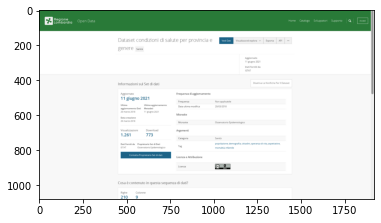

In [240]:
webpage_shot()

In [430]:
def extract_table_values(row):
  anno = ""
  provincia = ""
  genere = ""
  coordinata_x = ""
  coordinata_y = ""
  speranza_vita_nascita = ""
  tasso_mortalita = ""
  tasso_mortalita_infantile = ""
  posizione = ""
  date_loading = dt.date.today()
  
  try:
    anno = row.find_element_by_css_selector('td:nth-child(1)').text
    provincia = row.find_element_by_css_selector('td:nth-child(2)').text
    genere = row.find_element_by_css_selector('td:nth-child(3)').text
    coordinata_x = row.find_element_by_css_selector('td:nth-child(4)').text
    coordinata_y = row.find_element_by_css_selector('td:nth-child(5)').text
    speranza_vita_nascita = row.find_element_by_css_selector('td:nth-child(6)').text
    tasso_mortalita = row.find_element_by_css_selector('td:nth-child(7)').text
    tasso_mortalita_infantile = row.find_element_by_css_selector('td:nth-child(8)').text
    posizione = row.find_element_by_css_selector('td:nth-child(9)').text
  except:
    pass
  return {
          'date_loading': date_loading,
          'anno': anno,
          'provincia': provincia,
          'genere': genere,
          'coordinata_x': coordinata_x,
          'coordinata_y': coordinata_y,
          'speranza_vita_nascita': speranza_vita_nascita,
          'tasso_mortalita': tasso_mortalita,
          'tasso_mortalita_infantile': tasso_mortalita_infantile,
          'posizione':posizione
          }

In [431]:
rows_to_scrape = wd.find_element_by_css_selector('div > div > dl > div:nth-child(1) > dd')
num_rows = int(rows_to_scrape.text)
print('Total rows to scrape: ' + str(num_rows)) 

Total rows to scrape: 210


In [432]:
dataset_condizioni_salute_prov = []

num_pages = math.ceil(num_rows/13)

cnt = 0

for num in tqdm(range(1,num_pages+1)):
  table_socr = wd.find_element_by_css_selector("div.socrata-visualization-chart-container > div > table > tbody")
  t_cond_salute = table_socr.find_elements_by_tag_name("tr")
  for s in t_cond_salute:
    if cnt < num_rows:
      dataset_condizioni_salute_prov.append(extract_table_values(s))
      cnt = cnt +1
  next_button = wd.find_element_by_class_name('pager-button-next')
  if next_button.is_enabled():
    WebDriverWait(wd, delay).until(EC.element_to_be_clickable((By.CLASS_NAME, "pager-button-next")))
    next_button.click()
    time.sleep(delay)

  0%|          | 0/17 [00:00<?, ?it/s]

In [443]:
df_condizioni_salute_prov = pd.DataFrame(dataset_condizioni_salute_prov)
df_condizioni_salute_prov

,date_loading,anno,provincia,genere,coordinata_x,coordinata_y,speranza_vita_nascita,tasso_mortalita,tasso_mortalita_infantile,posizione
0,2021-11-14,2012,BERGAMO,F,"9,63853045","45,68012929","84,5","8,381804761882657","3,73","(45.68012929°, 9.63853045°)"
1,2021-11-14,2012,BRESCIA,F,"10,18167955","45,51939749",85,"8,654399715669228","4,1","(45.51939749°, 10.18167955°)"
2,2021-11-14,2012,COMO,F,"9,039360974","45,80216962","85,7","9,290944196983311","3,85","(45.80216962°, 9.039360974°)"
3,2021-11-14,2012,CREMONA,F,"10,0131151","45,13644491",84,"10,691872186630041","1,84","(45.13644491°, 10.0131151°)"
4,2021-11-14,2012,ITALIA,F,,,"84,4","10,24902789486484","3,15",
...,...,...,...,...,...,...,...,...,...,...
205,2021-11-14,2016,MONZA E DELLA BRIANZA,ALL,"9,258430902","45,5823624","83,9","8,444120384913555",,"(45.5823624°, 9.258430902°)"
206,2021-11-14,2016,PAVIA,ALL,"9,14034225","45,18407925",82,"12,180679470076527",,"(45.18407925°, 9.14034225°)"
207,2021-11-14,2016,REGIONE LOMBARDIA,ALL,,,"83,2","9,41714436364172",,
208,2021-11-14,2016,SONDRIO,ALL,"9,879429303","46,1707552","82,2","10,40895059603634",,"(46.1707552°, 9.879429303°)"


In [434]:
df_condizioni_salute_prov.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210 entries, 0 to 209
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   date_loading               210 non-null    object
 1   anno                       210 non-null    object
 2   provincia                  210 non-null    object
 3   genere                     210 non-null    object
 4   coordinata_x               210 non-null    object
 5   coordinata_y               210 non-null    object
 6   speranza_vita_nascita      210 non-null    object
 7   tasso_mortalita            210 non-null    object
 8   tasso_mortalita_infantile  210 non-null    object
 9   posizione                  210 non-null    object
dtypes: object(10)
memory usage: 16.5+ KB


In [308]:
wd.close()

### Transformations to perform on the data

In [444]:
def rename_columns(df):
  df.rename(columns={'date_loading':'DATE_LOADING',
                     'anno': 'ANNO',
                     'provincia':'PROVINCIA',
                     'genere':'GENERE',
                     'speranza_vita_nascita': 'SPERANZA_VITA_NASCITA',
                     'tasso_mortalita': 'TASSO_MORTALITA',
                     'tasso_mortalita_infantile': 'TASSO_MORTALITA_INFANTILE'},inplace=True)
  return df
#------------------------------------------------------------------------------------------------------------------------------------------ 
def drop_columns(df):
  df.drop(columns = ['coordinata_x',
                     'coordinata_y',
                     'posizione'
                     ],inplace=True)
  return df
#------------------------------------------------------------------------------------------------------------------------------------------ 
def convert_to_float(df):
    df['TASSO_MORTALITA'] = df['TASSO_MORTALITA'].apply(lambda x: x.replace(',','.'))
    df['TASSO_MORTALITA'] = df['TASSO_MORTALITA'].astype(float,errors='ignore')
    df['TASSO_MORTALITA_INFANTILE'] = df['TASSO_MORTALITA_INFANTILE'].apply(lambda x: x.replace(',','.'))
    df['TASSO_MORTALITA_INFANTILE'] = df['TASSO_MORTALITA_INFANTILE'].astype(float,errors='ignore')
    df['SPERANZA_VITA_NASCITA'] = df['SPERANZA_VITA_NASCITA'].apply(lambda x: x.replace(',','.'))
    df['SPERANZA_VITA_NASCITA'] = df['SPERANZA_VITA_NASCITA'].astype(float,errors='ignore')
    return df
#------------------------------------------------------------------------------------------------------------------------------------------ 
def round_tasso_mortalita(df):
  df['TASSO_MORTALITA'] = df['TASSO_MORTALITA'].apply(lambda x: np.round(x,decimals=2))
  return df

In [445]:
rename_columns(df_condizioni_salute_prov)
drop_columns(df_condizioni_salute_prov)
convert_to_float(df_condizioni_salute_prov)
round_tasso_mortalita(df_condizioni_salute_prov)

,DATE_LOADING,ANNO,PROVINCIA,GENERE,SPERANZA_VITA_NASCITA,TASSO_MORTALITA,TASSO_MORTALITA_INFANTILE
0,2021-11-14,2012,BERGAMO,F,84.5,8.38,3.73
1,2021-11-14,2012,BRESCIA,F,85.0,8.65,4.1
2,2021-11-14,2012,COMO,F,85.7,9.29,3.85
3,2021-11-14,2012,CREMONA,F,84.0,10.69,1.84
4,2021-11-14,2012,ITALIA,F,84.4,10.25,3.15
...,...,...,...,...,...,...,...
205,2021-11-14,2016,MONZA E DELLA BRIANZA,ALL,83.9,8.44,
206,2021-11-14,2016,PAVIA,ALL,82.0,12.18,
207,2021-11-14,2016,REGIONE LOMBARDIA,ALL,83.2,9.42,
208,2021-11-14,2016,SONDRIO,ALL,82.2,10.41,


### Loading

In [447]:
#Write data into the table in AZURE SQL Server database
%time
cxn= establish_db_connection()
df_condizioni_salute_prov.to_sql('WRH_PROVINCE_HEALTH',con=cxn,if_exists = 'append',index=False)
cxn.dispose()

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 6.91 µs
2021-11-14 22:13:21,415 INFO sqlalchemy.engine.Engine SELECT CAST(SERVERPROPERTY('ProductVersion') AS VARCHAR)


INFO:sqlalchemy.engine.Engine:SELECT CAST(SERVERPROPERTY('ProductVersion') AS VARCHAR)


2021-11-14 22:13:21,423 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2021-11-14 22:13:21,603 INFO sqlalchemy.engine.Engine SELECT schema_name()


INFO:sqlalchemy.engine.Engine:SELECT schema_name()


2021-11-14 22:13:21,607 INFO sqlalchemy.engine.Engine [generated in 0.00452s] ()


INFO:sqlalchemy.engine.Engine:[generated in 0.00452s] ()


2021-11-14 22:13:21,958 INFO sqlalchemy.engine.Engine SELECT CAST('test max support' AS NVARCHAR(max))


INFO:sqlalchemy.engine.Engine:SELECT CAST('test max support' AS NVARCHAR(max))


2021-11-14 22:13:21,961 INFO sqlalchemy.engine.Engine [generated in 0.00339s] ()


INFO:sqlalchemy.engine.Engine:[generated in 0.00339s] ()


2021-11-14 22:13:22,315 INFO sqlalchemy.engine.Engine SELECT [INFORMATION_SCHEMA].[TABLES].[TABLE_NAME] 
FROM [INFORMATION_SCHEMA].[TABLES] 
WHERE [INFORMATION_SCHEMA].[TABLES].[TABLE_TYPE] = CAST(? AS NVARCHAR(max)) AND [INFORMATION_SCHEMA].[TABLES].[TABLE_NAME] = CAST(? AS NVARCHAR(max)) AND [INFORMATION_SCHEMA].[TABLES].[TABLE_SCHEMA] = CAST(? AS NVARCHAR(max))


INFO:sqlalchemy.engine.Engine:SELECT [INFORMATION_SCHEMA].[TABLES].[TABLE_NAME] 
FROM [INFORMATION_SCHEMA].[TABLES] 
WHERE [INFORMATION_SCHEMA].[TABLES].[TABLE_TYPE] = CAST(? AS NVARCHAR(max)) AND [INFORMATION_SCHEMA].[TABLES].[TABLE_NAME] = CAST(? AS NVARCHAR(max)) AND [INFORMATION_SCHEMA].[TABLES].[TABLE_SCHEMA] = CAST(? AS NVARCHAR(max))


2021-11-14 22:13:22,322 INFO sqlalchemy.engine.Engine [generated in 0.00711s] ('BASE TABLE', 'WRH_PROVINCE_HEALTH', 'dbo')


INFO:sqlalchemy.engine.Engine:[generated in 0.00711s] ('BASE TABLE', 'WRH_PROVINCE_HEALTH', 'dbo')


2021-11-14 22:13:22,846 INFO sqlalchemy.engine.Engine BEGIN (implicit)


INFO:sqlalchemy.engine.Engine:BEGIN (implicit)


2021-11-14 22:13:22,857 INFO sqlalchemy.engine.Engine INSERT INTO [WRH_PROVINCE_HEALTH] ([DATE_LOADING], [ANNO], [PROVINCIA], [GENERE], [SPERANZA_VITA_NASCITA], [TASSO_MORTALITA], [TASSO_MORTALITA_INFANTILE]) VALUES (?, ?, ?, ?, ?, ?, ?)


INFO:sqlalchemy.engine.Engine:INSERT INTO [WRH_PROVINCE_HEALTH] ([DATE_LOADING], [ANNO], [PROVINCIA], [GENERE], [SPERANZA_VITA_NASCITA], [TASSO_MORTALITA], [TASSO_MORTALITA_INFANTILE]) VALUES (?, ?, ?, ?, ?, ?, ?)


2021-11-14 22:13:22,860 INFO sqlalchemy.engine.Engine [generated in 0.00595s] ((datetime.datetime(2021, 11, 14, 0, 0), '2012', 'BERGAMO', 'F', 84.5, 8.38, '3.73'), (datetime.datetime(2021, 11, 14, 0, 0), '2012', 'BRESCIA', 'F', 85.0, 8.65, '4.1'), (datetime.datetime(2021, 11, 14, 0, 0), '2012', 'COMO', 'F', 85.7, 9.29, '3.85'), (datetime.datetime(2021, 11, 14, 0, 0), '2012', 'CREMONA', 'F', 84.0, 10.69, '1.84'), (datetime.datetime(2021, 11, 14, 0, 0), '2012', 'ITALIA', 'F', 84.4, 10.25, '3.15'), (datetime.datetime(2021, 11, 14, 0, 0), '2012', 'LECCO', 'F', 85.5, 8.77, '1.27'), (datetime.datetime(2021, 11, 14, 0, 0), '2012', 'LODI', 'F', 83.7, 9.64, '0.9'), (datetime.datetime(2021, 11, 14, 0, 0), '2012', 'MANTOVA', 'F', 84.6, 10.54, '2.07')  ... displaying 10 of 210 total bound parameter sets ...  (datetime.datetime(2021, 11, 14, 0, 0), '2016', 'SONDRIO', 'ALL', 82.2, 10.41, ''), (datetime.datetime(2021, 11, 14, 0, 0), '2016', 'VARESE', 'ALL', 83.4, 9.67, ''))


INFO:sqlalchemy.engine.Engine:[generated in 0.00595s] ((datetime.datetime(2021, 11, 14, 0, 0), '2012', 'BERGAMO', 'F', 84.5, 8.38, '3.73'), (datetime.datetime(2021, 11, 14, 0, 0), '2012', 'BRESCIA', 'F', 85.0, 8.65, '4.1'), (datetime.datetime(2021, 11, 14, 0, 0), '2012', 'COMO', 'F', 85.7, 9.29, '3.85'), (datetime.datetime(2021, 11, 14, 0, 0), '2012', 'CREMONA', 'F', 84.0, 10.69, '1.84'), (datetime.datetime(2021, 11, 14, 0, 0), '2012', 'ITALIA', 'F', 84.4, 10.25, '3.15'), (datetime.datetime(2021, 11, 14, 0, 0), '2012', 'LECCO', 'F', 85.5, 8.77, '1.27'), (datetime.datetime(2021, 11, 14, 0, 0), '2012', 'LODI', 'F', 83.7, 9.64, '0.9'), (datetime.datetime(2021, 11, 14, 0, 0), '2012', 'MANTOVA', 'F', 84.6, 10.54, '2.07')  ... displaying 10 of 210 total bound parameter sets ...  (datetime.datetime(2021, 11, 14, 0, 0), '2016', 'SONDRIO', 'ALL', 82.2, 10.41, ''), (datetime.datetime(2021, 11, 14, 0, 0), '2016', 'VARESE', 'ALL', 83.4, 9.67, ''))


2021-11-14 22:13:59,507 INFO sqlalchemy.engine.Engine COMMIT


INFO:sqlalchemy.engine.Engine:COMMIT


2021-11-14 22:13:59,693 INFO sqlalchemy.engine.Engine SELECT [INFORMATION_SCHEMA].[TABLES].[TABLE_NAME] 
FROM [INFORMATION_SCHEMA].[TABLES] 
WHERE [INFORMATION_SCHEMA].[TABLES].[TABLE_SCHEMA] = CAST(? AS NVARCHAR(max)) AND [INFORMATION_SCHEMA].[TABLES].[TABLE_TYPE] = CAST(? AS NVARCHAR(max)) ORDER BY [INFORMATION_SCHEMA].[TABLES].[TABLE_NAME]


INFO:sqlalchemy.engine.Engine:SELECT [INFORMATION_SCHEMA].[TABLES].[TABLE_NAME] 
FROM [INFORMATION_SCHEMA].[TABLES] 
WHERE [INFORMATION_SCHEMA].[TABLES].[TABLE_SCHEMA] = CAST(? AS NVARCHAR(max)) AND [INFORMATION_SCHEMA].[TABLES].[TABLE_TYPE] = CAST(? AS NVARCHAR(max)) ORDER BY [INFORMATION_SCHEMA].[TABLES].[TABLE_NAME]


2021-11-14 22:13:59,696 INFO sqlalchemy.engine.Engine [generated in 0.00327s] ('dbo', 'BASE TABLE')


INFO:sqlalchemy.engine.Engine:[generated in 0.00327s] ('dbo', 'BASE TABLE')


## Dataset assistenza ospedaliera - Source: API Socrata

In [218]:
data_url = 'dati.lombardia.it'                        # The Host Name for the API endpoint (the https:// part will be added automatically)
data_set = '3rtw-8p48'                                # The data set at the API endpoint
app_token = os.getenv('qEei2HKE5SldzRBJyNJqp9Wjw')    # The app token
limit_rows = 100000

In [231]:
client = Socrata(data_url,app_token)
# Set the timeout to 60 seconds    
client.timeout = 60
# The SoDaPy library converts this CSV object to a Python list of dictionaries
results = client.get(data_set,limit=limit_rows)
# Convert the list of dictionaries to a Pandas data frame
df_ats_assistance = pd.DataFrame.from_records(results)

In [232]:
df_ats_assistance.head()

,anno,codice_ats_residenza,descrizione_ats_residenza,coordinata_geografica_x,coordinata_geografica_y,posizione_ats,codice_acc_di_diagnosi,descrizione_acc_di_diagnosi,tasso_ricoveri_stessa_ats,tasso_ricoveri_altra_ats,:@computed_region_ttgh_9sm5,:@computed_region_6hky_swhk,:@computed_region_af5v_nc64
0,2014,324,ATS DELLA BRIANZA,9.298423314,45.69919245,"{'type': 'Point', 'coordinates': [9.298423314, 45.69919245]}",128,ASMA,0.0,0.36892458483520535,10,10,5
1,2013,323,ATS DELLA MONTAGNA,10.32968894,46.33431031,"{'type': 'Point', 'coordinates': [10.32968894, 46.33431031]}",4,MICOSI,0.0,0.035604716438104166,3,3,7
2,2015,325,ATS DI BERGAMO,9.63853045,45.68701679,"{'type': 'Point', 'coordinates': [9.63853045, 45.68701679]}",88,GLAUCOMA,0.0,0.11092543375902847,5,5,1
3,2015,326,ATS DI BRESCIA,10.25368782,45.65171815,"{'type': 'Point', 'coordinates': [10.25368782, 45.65171815]}",39,LEUCEMIE,0.0,0.17010908459834068,6,6,2
4,2012,325,ATS DI BERGAMO,9.63853045,45.68701679,"{'type': 'Point', 'coordinates': [9.63853045, 45.68701679]}",123,INFLUENZA,0.0,0.0174810698414743,5,5,1


In [226]:
df_ats_assistance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16737 entries, 0 to 16736
Data columns (total 13 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   anno                         16737 non-null  object
 1   codice_ats_residenza         16737 non-null  object
 2   descrizione_ats_residenza    16737 non-null  object
 3   coordinata_geografica_x      16737 non-null  object
 4   coordinata_geografica_y      16737 non-null  object
 5   posizione_ats                16737 non-null  object
 6   codice_acc_di_diagnosi       16737 non-null  object
 7   descrizione_acc_di_diagnosi  16737 non-null  object
 8   tasso_ricoveri_stessa_ats    16737 non-null  object
 9   tasso_ricoveri_altra_ats     16737 non-null  object
 10  :@computed_region_ttgh_9sm5  16737 non-null  object
 11  :@computed_region_6hky_swhk  16737 non-null  object
 12  :@computed_region_af5v_nc64  16737 non-null  object
dtypes: object(13)
memory usage: 1.7

### Transformations to perform on the data

In [233]:
def rename_columns(df):
  df.rename(columns={'anno':'ANNO',
                     'codice_ats_residenza': 'COD_ATS',
                     'coordinata_geografica_x':'COORDINATA_X',
                     'coordinata_geografica_y':'COORDINATA_Y',
                     'codice_acc_di_diagnosi': 'COD_ACC_DIAGNOSI',
                     'tasso_ricoveri_stessa_ats': 'TASSO_RICOVERI_STESSA_ATS',
                     'tasso_ricoveri_altra_ats': 'TASSO_RICOVERI_ALTRA_ATS'},inplace=True)
  return df
#------------------------------------------------------------------------------------------------------------------------------------------ 
def drop_columns(df):
  df.drop(columns = ['descrizione_ats_residenza',
                     'posizione_ats',
                     ':@computed_region_ttgh_9sm5',
                     ':@computed_region_6hky_swhk',
                     ':@computed_region_af5v_nc64'
                     ],inplace=True)
  return df

In [234]:
rename_columns(df_ats_assistance)
drop_columns(df_ats_assistance)

COORDINATA_X  ... TASSO_RICOVERI_ALTRA_ATS
ANNO COD_ATS COD_ACC_DIAGNOSI               ...                         
2014 324     128               9.298423314  ...      0.36892458483520535
2013 323     4                 10.32968894  ...     0.035604716438104166
2015 325     88                 9.63853045  ...      0.11092543375902847
     326     39                10.25368782  ...      0.17010908459834068
2012 325     123                9.63853045  ...       0.0174810698414743
...                                    ...  ...                      ...
2017 321     130               9.198811423  ...       0.0345173760180813
     323     16                10.32968894  ...       0.3416974937231656
             56                10.32968894  ...     0.026741542987030353
2016 326     9                 10.25368782  ...                      0.0
2017 328     154                9.14034225  ...     0.010963890426879074

[16737 rows x 5 columns]

### Loading

## Performance degli Ospedali - Source: Azure SQL Database

### Data ingestion

In [212]:
def establish_db_connection():
  server = "airadav-work.database.windows.net"
  database = "hospitalization-lombardy"
  username = "admindav"
  password = "Password01"

  driver = '{ODBC Driver 17 for SQL Server}'

  odbc_str = 'DRIVER='+driver+';SERVER='+server+';PORT=1433;UID='+username+';DATABASE='+ database + ';PWD='+ password
  connect_str = 'mssql+pyodbc:///?odbc_connect=' + urllib.parse.quote(odbc_str)
  engine = create_engine(connect_str,echo = True)
  return engine

In [214]:
%time
cxn= establish_db_connection()
df_performance_hospital = pd.read_sql_query("SELECT * FROM dbo.EXT_PERFORMANCE_HOSPITAL",con=cxn)
cxn.dispose()

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 11.7 µs
2021-11-14 17:19:00,061 INFO sqlalchemy.engine.Engine SELECT CAST(SERVERPROPERTY('ProductVersion') AS VARCHAR)
2021-11-14 17:19:00,064 INFO sqlalchemy.engine.Engine [raw sql] ()
2021-11-14 17:19:00,244 INFO sqlalchemy.engine.Engine SELECT schema_name()
2021-11-14 17:19:00,246 INFO sqlalchemy.engine.Engine [generated in 0.00181s] ()
2021-11-14 17:19:00,605 INFO sqlalchemy.engine.Engine SELECT CAST('test max support' AS NVARCHAR(max))
2021-11-14 17:19:00,607 INFO sqlalchemy.engine.Engine [generated in 0.00182s] ()
2021-11-14 17:19:00,962 INFO sqlalchemy.engine.Engine SELECT * FROM dbo.EXT_PERFORMANCE_HOSPITAL
2021-11-14 17:19:00,964 INFO sqlalchemy.engine.Engine [raw sql] ()


In [197]:
df_performance_hospital.head()

,PERIODO,CODICE_STRUTTURA,DENOMINAZIONE_STRUTTURA,NUM_TOTALE_RICOVERI,NUM_DIMISSIONI_VOLONTARIE,NUM_TOTALE_DIMISSIONI,NUM_TRASFERIMENTI_FRA_STRUTTURE,NUM_RICOVERI_RIPETUTI,NUM_RITORNI_IN_SALA_OPERATORIA,NUM_DI_RICOVERI_DI_TIPO_CHIRURGICO
0,2010,030004-00,OSPEDALE DI CIRCOLO - BUSTO ARSIZIO,23103,38,8348,22,862,49.0,3706
1,2010,030006-00,OSP. S. ANTONIO ABATE - GALLARATE,18719,83,7416,55,566,30.0,2662
2,2010,030008-00,OSP. GENERALE PROVINCIALE - SARONNO,15559,71,7006,24,645,50.0,2501
3,2010,030009-00,OSP. CIRCOLO A.BELLINI - SOMMA LOMBARDO,2858,14,1012,4,35,0.0,2
4,2010,030010-00,OSPEDALE DI CIRCOLO GALMARINI - TRADATE,10640,22,4124,18,326,11.0,2049


[Modello di valutazione performance ospdealiera](http://www.archiviodocumenti.info/download/Manuale%20Modello%20Valutazione.pdf)


Possiamo fare una valutazione KPI Ospedale vs AVG del totale

##### Valutazione performance EX POST
---

KPI: NUM_RITORNI_IN_SALA_OPERATORIA/NUM_TOTALE_RICOVERI_DI_TIPO_CHIRURGICO
Questo indicatore può evidenziare problemi in termini di efficacia degli interventi chirurgici erogati dalla struttura.

---

KPI: NUM_TOTALE_RICOVERI_RIPETUTI/ NUM_TOTALE_RICOVERI

Questo indicatore può evidenziare o la tendenza a frammentare i processi di erogazione delle cure o problemi in termini di efficacia delle stesse.

---

KPI: NUM_TOTALE_DIMISSIONI_VOLONTARIE/ NUM_TOTALI_DIMISSIONI

L’esperienza clinica quotidiana ci suggerisce che per la stragrande maggioranza i casi di dimissioni volontarie sono dovute a scelte di proseguire le cure presso altre strutture o di affidarsi a un clinico diverso dal primo con cui si viene a contatto. 


### Transformations to perform on the data

In [207]:
def rename_columns(df):
  df.rename(columns={'PERIODO': 'ANNO','CODICE_STRUTTURA':'COD_STRUTTURA'},inplace=True)
  return df
#------------------------------------------------------------------------------------------------------------------------------------------ 
def drop_columns(df):
  df.drop(columns = ['DENOMINAZIONE_STRUTTURA'],inplace=True)
  return df
#------------------------------------------------------------------------------------------------------------------------------------------ 
def set_index_on_ds(df):
  df.set_index(['ANNO','COD_STRUTTURA'],inplace=True)
  return df

In [216]:
rename_columns(df_performance_hospital)
drop_columns(df_performance_hospital)
set_index_on_ds(df_performance_hospital)

NUM_TOTALE_RICOVERI  ...  NUM_DI_RICOVERI_DI_TIPO_CHIRURGICO
ANNO COD_STRUTTURA                       ...                                    
2010 030004-00                    23103  ...                                3706
     030006-00                    18719  ...                                2662
     030008-00                    15559  ...                                2501
     030009-00                     2858  ...                                   2
     030010-00                    10640  ...                                2049
...                                 ...  ...                                 ...
2019 030131-00                    12602  ...                                2988
     030367-00                    13446  ...                                1196
     030949-00                     2436  ...                                   0
     030035-00                     3202  ...                                1474
     030383-00                     4374  ...                                 574

[1377 rows x 7 columns]

### Loading

In [217]:
#Write data into the table in AZURE SQL Server database
%time
cxn= establish_db_connection()
df_performance_hospital.to_sql('WRH_PERFORMANCE_HOSPITAL',cxn,if_exists = 'append')
cxn.dispose()

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 6.44 µs
2021-11-14 17:20:12,915 INFO sqlalchemy.engine.Engine SELECT CAST(SERVERPROPERTY('ProductVersion') AS VARCHAR)
2021-11-14 17:20:12,918 INFO sqlalchemy.engine.Engine [raw sql] ()
2021-11-14 17:20:13,098 INFO sqlalchemy.engine.Engine SELECT schema_name()
2021-11-14 17:20:13,100 INFO sqlalchemy.engine.Engine [generated in 0.00151s] ()
2021-11-14 17:20:13,453 INFO sqlalchemy.engine.Engine SELECT CAST('test max support' AS NVARCHAR(max))
2021-11-14 17:20:13,455 INFO sqlalchemy.engine.Engine [generated in 0.00183s] ()
2021-11-14 17:20:13,812 INFO sqlalchemy.engine.Engine SELECT [INFORMATION_SCHEMA].[TABLES].[TABLE_NAME] 
FROM [INFORMATION_SCHEMA].[TABLES] 
WHERE [INFORMATION_SCHEMA].[TABLES].[TABLE_TYPE] = CAST(? AS NVARCHAR(max)) AND [INFORMATION_SCHEMA].[TABLES].[TABLE_NAME] = CAST(? AS NVARCHAR(max)) AND [INFORMATION_SCHEMA].[TABLES].[TABLE_SCHEMA] = CAST(? AS NVARCHAR(max))
2021-11-14 17:20:13,814 INFO sqlalchemy.engine.